In [2]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

In [3]:
from mtr.models import model as model_utils
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset import WaymoDataset
from tools.mtr_env import BatchMTREnv
from tools.mtr_inference import MTRInference
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent



cfg_file = 'tools/cfgs/waymo/bc+10_percent_data.yaml'
ckpt_path = 'output/bc/epoch=2-step=4602.ckpt'
cfg = cfg_from_yaml_file(cfg_file, cfg)

dataset = WaymoDataset(cfg.DATA_CONFIG, training=False)
mtr_inference = MTRInference(cfg_file)
mtr_inference.load_from_checkpoint(ckpt_path)
mtr_inference.model.eval()
env = BatchMTREnv(1, dataset)


=========== MTR Inference ===========


In [739]:
def sample_control(pred_ctrl, pred_ctrl_score, log_std_range=(-4.0, -1.0), rho_limit=0.4):
    '''
    Construct a Gaussian Mixture Model for the control sampling
    input:
        pred_ctrl: (num_center_objects, num_query, 6 or 9)
        pred_ctrl_score: (num_center_objects, num_query)
    output:
    '''
    
    independent = pred_ctrl.shape[-1] == 6
    
    mean = pred_ctrl[..., 0:3] # (num_center_objects, num_query, 3)
    log_std1 = torch.clip(pred_ctrl[..., 3], min=log_std_range[0], max=log_std_range[1])
    log_std2 = torch.clip(pred_ctrl[..., 4], min=log_std_range[0], max=log_std_range[1])
    log_std3 = torch.clip(pred_ctrl[..., 5], min=log_std_range[0], max=log_std_range[1])
    std1 = torch.exp(log_std1)
    std2 = torch.exp(log_std2)
    std3 = torch.exp(log_std3)
    # print(std1)
    # print(std2)
    # print(std3)
    if independent:
        rho1 = rho2 = rho3 = torch.zeros_like(log_std1)
    else:
        rho1 = torch.clip(pred_ctrl[..., 6], min=-rho_limit, max=rho_limit) # 1&2
        rho2 = torch.clip(pred_ctrl[..., 7], min=-rho_limit, max=rho_limit) # 1&3
        rho3 = torch.clip(pred_ctrl[..., 8], min=-rho_limit, max=rho_limit) # 2&3 
        
    covariance = torch.stack([
        torch.stack([std1**2, rho1*std1*std2, rho2*std1*std3], dim=-1),
        torch.stack([rho1*std1*std2, std2**2, rho3*std2*std3], dim=-1),
        torch.stack([rho2*std1*std3, rho3*std2*std3, std3**2], dim=-1),
    ], dim=-1) # (num_center_objects, num_query, 3, 3)
    # print(covariance)
    dist_mode = MultivariateNormal(mean, covariance_matrix=covariance)
    # print(dist_mode.batch_shape, dist_mode.event_shape)
    mix = Categorical(logits=pred_ctrl_score)
    gmm = MixtureSameFamily(mix, dist_mode)
    return gmm

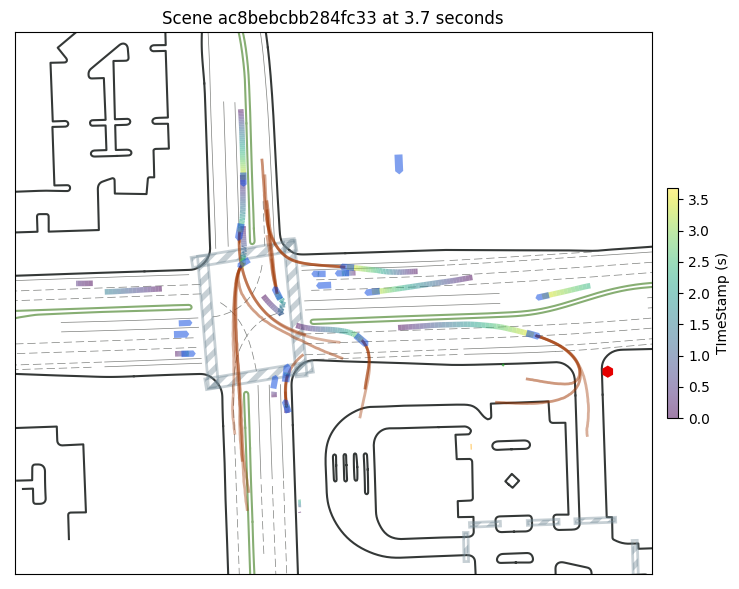

In [769]:
# _ = env.reset()
batch_scene_data = env.batch_scene_data
with torch.no_grad():
    batch_pred_dicts = mtr_inference.inference(batch_scene_data)
_ = env.visualize(batch_dict= batch_pred_dicts)
pred_ctrl = batch_pred_dicts['pred_ctrl']
pred_ctrl_scores = batch_pred_dicts['pred_ctrl_scores']
# print(torch.argmax(pred_ctrl_scores))
gmm = sample_control(pred_ctrl, pred_ctrl_scores)
action = gmm.sample()
# print(gmm.log_prob(action))
action = action.cpu().numpy()
# print(pred_ctrl[ :, :6])
# print(action)
_ = env.step(action)

plt.plot(action[:, 0], action[:, 1], 'o')

In [657]:
env.envs_list[0].index

1261

[5.762089e-15, 2.9970958e-12, 3.978626e-12, 1.1973768e-11, 1.2870799e-11, 5.3217184e-11, 7.630428e-11, 8.176985e-11, 1.2330346e-10, 1.4617674e-10, 1.559716e-10, 2.732332e-10, 3.5114703e-10, 1.7439569e-09, 2.004535e-09, 2.3449653e-09, 3.4658454e-09, 3.8843924e-09, 3.896212e-09, 5.294388e-09, 5.4311795e-09, 6.9836488e-09, 8.587479e-09, 1.0794867e-08, 1.0828666e-08, 1.2229294e-08, 1.2365709e-08, 1.4909807e-08, 1.7991521e-08, 1.8257845e-08, 1.9914381e-08, 2.4058973e-08, 4.9927525e-08, 5.1720033e-08, 5.2046197e-08, 5.3860184e-08, 5.4749385e-08, 7.109449e-08, 8.758109e-08, 1.802827e-07, 2.6904448e-07, 5.453232e-07, 6.604606e-07, 7.5805207e-07, 2.7107926e-06, 3.0897318e-06, 5.012218e-06, 5.5814103e-06, 7.15492e-06, 8.758009e-06, 1.1716818e-05, 1.7048327e-05, 3.0213218e-05, 3.513623e-05, 3.608769e-05, 4.5531455e-05, 0.00010285242, 0.00017761494, 0.0003391236, 0.00040956974, 0.00064035814, 0.005580019, 0.020982234, 0.97155726]
(100, 5, 64, 3)


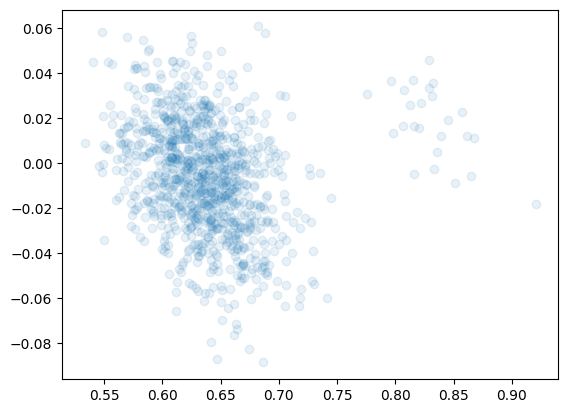

In [15]:
pred_ctrl = batch_pred_dicts['pred_ctrl']
pred_ctrl_scores = batch_pred_dicts['pred_ctrl_scores']
print(sorted(torch.functional.F.softmax(pred_ctrl_scores, dim=-1)[0].cpu().numpy()))

gmm, dist_mode, mix = sample_control(pred_ctrl, pred_ctrl_scores)
gmm_samples = gmm.sample((1000,)).cpu().numpy()
gaussian_samples = dist_mode.sample((100,)).cpu().numpy()
print(gaussian_samples.shape)
i = 0
# _ = plt.plot(gaussian_samples[:,0,:,0], gaussian_samples[:,0,:,1], 'x', alpha=0.1)
plt.plot(gmm_samples[:, i, 0], gmm_samples[:, i, 1], 'o', alpha=0.1)
